In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%config Completer.use_jedi = True

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-exchange-data/indexProcessed.csv
/kaggle/input/stock-exchange-data/indexData.csv
/kaggle/input/stock-exchange-data/indexInfo.csv


In [40]:
if(os.path.exists('/kaggle/input/stock-exchange-data/indexProcessed.csv')):
    indexStockData = pd.read_csv('/kaggle/input/stock-exchange-data/indexProcessed.csv', index_col = 1)
    
hsiStock = indexStockData.loc[indexStockData["Index"]=="HSI"]
hsiStock = hsiStock.loc["1990-01-01":].copy()
hsiStock['Tomorrow'] = hsiStock['Open'].shift(-1)
hsiStock = hsiStock[:-1]
hsiStock["Target"] =( hsiStock["Close"]<hsiStock["Tomorrow"]).astype(int)
hsiStock


,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Tomorrow,Target
Date,,,,,,,,,,
1990-01-02,HSI,2836.00000,2851.00000,2798.00000,2838.100098,2838.100098,0.000000e+00,368.953013,2836.00000,0
1990-01-03,HSI,2836.00000,2873.00000,2836.00000,2858.699951,2858.699951,0.000000e+00,371.630994,2858.00000,0
1990-01-04,HSI,2858.00000,2876.00000,2850.00000,2868.000000,2868.000000,0.000000e+00,372.840000,2867.00000,0
1990-01-05,HSI,2867.00000,2875.00000,2838.00000,2839.899902,2839.899902,0.000000e+00,369.186987,2839.00000,0
1990-01-08,HSI,2839.00000,2839.00000,2815.00000,2816.000000,2816.000000,0.000000e+00,366.080000,2816.00000,0
...,...,...,...,...,...,...,...,...,...,...
2021-05-24,HSI,28417.99023,28444.35938,28195.51953,28412.259770,28412.259770,1.719641e+09,3693.593770,28461.50000,1
2021-05-25,HSI,28461.50000,28929.24023,28461.50000,28910.859380,28910.859380,2.352078e+09,3758.411719,29056.27930,1
2021-05-26,HSI,29056.27930,29261.85938,29027.94922,29166.009770,29166.009770,2.518538e+09,3791.581270,28998.39063,0


In [41]:
# model = RandomForestClassifier(n_estimators =100, random_state=1, min_samples_split=100)

model = Sequential([Dense(units = 100, activation = 'relu'),Dense(units = 100, activation = 'relu'),Dense(units = 25, activation = 'relu'),Dense(units = 1, activation = 'softmax')])
model.compile(loss = BinaryCrossentropy())

def trainAndPredict(model, test, train, predictors):
    model.fit(train[predictors], train["Target"], epochs=25)
    predictions = model.predict(test[predictors])
    
    predictions[predictions>0.6] = 1
    predictions[predictions<=0.6] = 0
    
#     model.fit(train[predictors], train["Target"])
#     predictions = model.predict(test[predictors])
##    we can also use model.predict_proba() to predict probability
    
    predictions = pd.Series(predictions.flatten(), index=test.index, name = "Predictions")
    
    return pd.concat([test["Target"], predictions], axis =1)

def backTest(model, data , predictors):
    allPredictions = pd.DataFrame()
    
    for i in range(2500, data.shape[0], 500):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i+500].copy()
        predictions = trainAndPredict(model, test, train,predictors)
        allPredictions = pd.concat([allPredictions, predictions])
        
    return allPredictions

In [42]:
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "CloseUSD"]

In [43]:
hsiStock
windows = [2,4,8,16,32,64,128,256,512,1024]

for window in windows:
    newColumn =f'{window}DayAverage'
    hsiStock[newColumn] = hsiStock['Close'].rolling(window).mean()
    features.append(newColumn)
    
    newColumn = f'{window}DaySum'
    hsiStock[newColumn] = hsiStock['Close'].shift(1).rolling(window).sum()
    features.append(newColumn)

    newColumn=f'{window}DayRatio'
    hsiStock[newColumn] = hsiStock['Close']/hsiStock[f'{window}DayAverage']
    features.append(newColumn)
    
hsiStock = hsiStock.dropna()
hsiStock
    

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Tomorrow,Target,...,128DayRatio,256DayAverage,256DaySum,256DayRatio,512DayAverage,512DaySum,512DayRatio,1024DayAverage,1024DaySum,1024DayRatio
Date,,,,,,,,,,,,,,,,,,,,,
1994-02-15,HSI,10934.79981,11012.29981,10790.40039,11012.29981,11012.29981,0.000000e+00,1431.598975,11051.00000,1,...,1.173069,8073.400399,2.061525e+06,1.364023,6823.646102,3.487295e+06,1.613844,5136.654986,5.251761e+06,2.143866
1994-02-16,HSI,11051.00000,11119.50000,10634.09961,10634.09961,10634.09961,0.000000e+00,1382.432949,10716.00000,1,...,1.129684,8092.335553,2.066791e+06,1.314095,6835.519929,3.493707e+06,1.555712,5144.248149,5.259935e+06,2.067182
1994-02-17,HSI,10716.00000,10819.29981,10477.40039,10786.59961,10786.59961,0.000000e+00,1402.257949,10877.79981,1,...,1.142666,8111.855473,2.071638e+06,1.329733,6847.629890,3.499786e+06,1.575231,5151.981157,5.267710e+06,2.093680
1994-02-18,HSI,10877.79981,10905.59961,10729.29981,10825.90039,10825.90039,0.000000e+00,1407.367051,10761.70020,0,...,1.143671,8131.348833,2.076635e+06,1.331378,6859.846297,3.505987e+06,1.578155,5159.779985,5.275629e+06,2.098132
1994-02-21,HSI,10761.70020,10761.70020,10439.29981,10456.50000,10456.50000,0.000000e+00,1359.345000,10424.79981,0,...,1.101984,8149.315630,2.081625e+06,1.283114,6871.340437,3.512241e+06,1.521755,5167.241411,5.283615e+06,2.023614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,HSI,28417.99023,28444.35938,28195.51953,28412.25977,28412.25977,1.719641e+09,3693.593770,28461.50000,1,...,1.003649,26497.787110,6.779623e+06,1.072250,26604.223698,1.362256e+07,1.067960,27358.976984,2.801154e+07,1.038499
2021-05-25,HSI,28461.50000,28929.24023,28461.50000,28910.85938,28910.85938,2.352078e+09,3758.411719,29056.27930,1,...,1.020549,26516.010468,6.783434e+06,1.090317,26602.305825,1.362136e+07,1.086780,27363.583586,2.801559e+07,1.056545
2021-05-26,HSI,29056.27930,29261.85938,29027.94922,29166.00977,29166.00977,2.518538e+09,3791.581270,28998.39063,0,...,1.028776,26535.485894,6.788099e+06,1.099132,26601.264614,1.362038e+07,1.096414,27368.290755,2.802031e+07,1.065686


In [44]:
predictions = backTest(model, hsiStock, features)
precision_score(predictions["Target"], predictions["Predictions"])


Epoch 1/25
79/79 [==============================] - 1s 2ms/step - loss: 596502.5000
Epoch 2/25
79/79 [==============================] - 0s 2ms/step - loss: 295065.2812
Epoch 3/25
79/79 [==============================] - 0s 2ms/step - loss: 185214.4062
Epoch 4/25
79/79 [==============================] - 0s 2ms/step - loss: 141157.7969
Epoch 5/25
79/79 [==============================] - 0s 2ms/step - loss: 88237.0859
Epoch 6/25
79/79 [==============================] - 0s 2ms/step - loss: 79384.5938
Epoch 7/25
79/79 [==============================] - 0s 2ms/step - loss: 43162.5352
Epoch 8/25
79/79 [==============================] - 0s 2ms/step - loss: 24631.9238
Epoch 9/25
79/79 [==============================] - 0s 2ms/step - loss: 13229.6475
Epoch 10/25
79/79 [==============================] - 0s 2ms/step - loss: 11095.0596
Epoch 11/25
79/79 [==============================] - 0s 2ms/step - loss: 4499.3623
Epoch 12/25
79/79 [==============================] - 0s 2ms/step - loss: 2681.0422

0.572882158069096

In [24]:
#compare with this
predictions["Target"].sum()/ predictions.shape[0]

0.5611428571428572

<Axes: xlabel='Date'>

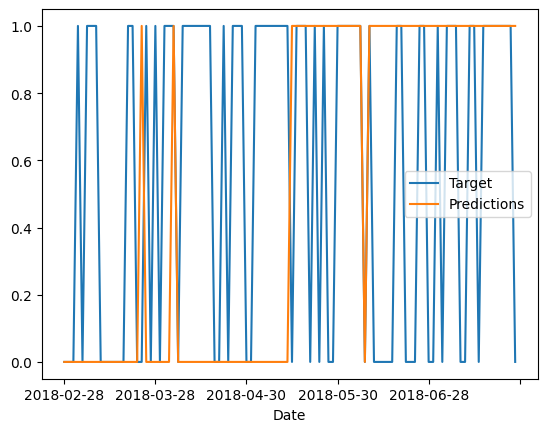

In [19]:
predictions.iloc[-800:-700].plot()

In [ ]:
model.save("model2.keras")